In [1]:
import os

from nlb_tools.nwb_interface import NWBDataset
import numpy as np
import matplotlib.pyplot as plt
import torch
from typing import List

from sparks.models.encoders import HebbianTransformerEncoder
from sparks.models.decoders import mlp

# Overview

This notebook is a demonstration of SPARKS using the Area2_Bump dataset from the Neural Latents Benchmark (https://neurallatents.github.io/)
It assumes some familiarity with the data, to get an overview of it please see: https://github.com/neurallatents/neurallatents.github.io/blob/master/notebooks/area2_bump.ipynb.
In the following, we only consider passive recordings. We will go through the creation of custom Pytorch datasets for loading of the data, training of the algorithm, and some analysis of the results

First, let's obtain the hand positions and corresponding neural responses for each trial in this session.

In [2]:
target_key = 'hand_pos'  # Behavioural target that we're considering

dataset_path = "/Volumes/lab-iacarusof/home/shared/Nicolas/datasets/000127/sub-Han/"  # Change to your local path
dataset = NWBDataset(dataset_path, "*train", split_heldout=False) # NWB dataset

trial_mask = (~dataset.trial_info.ctr_hold_bump) & (dataset.trial_info.split != 'none') # Keep only active trials  
unique_angles = [0.0, 45.0, 90.0, 135.0, 180.0, 225.0, 270.0, 315.0] # Targets angles

lag = 40  # Assumed lag between neural data and behaviour, taken from the NLB notebook
align_range = (-100, 500)  # 100 ms before to 500 ms after the stimulus onset
align_field = 'move_onset_time'

lag_align_range = (align_range[0] + lag, align_range[1] + lag)

# Obtain a list of hand positions over time for each angle
target_data = [dataset.make_trial_data(align_field=align_field,
                                        align_range=lag_align_range,
                                        ignored_trials=~(trial_mask &
                                                         (dataset.trial_info['cond_dir'] == angle)))[target_key].to_numpy()
                for angle in unique_angles]

# Obtain a list of corresponding neural recordings
spiking_data = [dataset.make_trial_data(align_field=align_field,
                                      align_range=align_range,
                                      ignored_trials=~(trial_mask & (dataset.trial_info['cond_dir'] == angle)))
              for angle in unique_angles]

trial_ids = [spiking_data[i]['trial_id'].to_numpy() for i in range(len(spiking_data))]  # Obtain the unique id corresponding to each trial at each timestep
unique_ids = [np.unique(trial_ids[i]) for i in range(len(trial_ids))] # Obtain the id corresponding to each trial

/Users/skatchn/miniconda3/envs/attention-vae/lib/python3.10/site-packages/pandas/core/arrays/timedeltas.py:1014: RuntimeWarning: invalid value encountered in cast
  base = data.astype(np.int64)
/Users/skatchn/miniconda3/envs/attention-vae/lib/python3.10/site-packages/pandas/core/arrays/timedeltas.py:1018: RuntimeWarning: invalid value encountered in cast
  data = (base * m + (frac * m).astype(np.int64)).view("timedelta64[ns]")


Next, we create a dataset to load the data efficiently. A Pytorch Dataset is essentially an iterable that will retrieve the inputs (here, neural data) and targets (hand position) for each trial.
They typically handle behind the scene whatever transformation you want to apply to each example individually (for instance, downsampling of the images if you're doing computer vision). 

In [3]:
def normalize(x):
    """ 
    Normalises the input to [0, 1]
    """
    return (x - np.min(x)) / (np.max(x) - np.min(x))

class MonkeyReachingDataset(torch.utils.data.Dataset):
    def __init__(
            self,
            spiking_data: List,
            target_data: List,
            unique_ids: List,
            trial_ids: List,
            p_train: float = 1.,
            train: bool = True,
            normalize_targets: bool = True) -> None:

        """
        Dataset class for the monkey reaching data from the NLB competition.  

        Parameters
        --------------------------------------
        :param: align_data : list of examples comprising the neural responses per angle
        :param: y_trial_data: corresponding targets
        :param: unique_ids: unique id matching each trial to an angle
        :param: trial_ids: id of each trial
        :param: p_trail: proportion of trials to use for training
        :param: train: True/False
        :param: normalize_targets: targets should be normalised to [0, 1] with the BCELoss
        """

        super(MonkeyReachingDataset).__init__()
        
        # Select the train/test indices
        if train:
            self.indices = [unique_ids[i][:int(len(unique_ids[i]) * p_train)] for i in range(len(unique_ids))]
        else:
            self.indices = [unique_ids[i][int(len(unique_ids[i]) * p_train):] for i in range(len(unique_ids))]
        
        # Spiking data
        self.x_trial_data = np.vstack([np.vstack([spiking_data[i]['spikes'].to_numpy()[trial_ids[i] == idx][None, :]
                                                  for idx in self.indices[i]]) for i in
                                       range(len(spiking_data))]).transpose([0, 2, 1])
        
        # Targets
        if normalize_targets:
            self.target_data = normalize(np.vstack([np.vstack([target_data[i][trial_ids[i] == idx][None, :]
                                                                for idx in self.indices[i]]) for i in
                                                     range(len(spiking_data))]).transpose([0, 2, 1]))
        else:
            self.target_data = np.vstack([np.vstack([target_data[i][trial_ids[i] == idx][None, :]
                                                      for idx in self.indices[i]]) for i in
                                           range(len(spiking_data))]).transpose([0, 2, 1])
        
        self.y_shape = self.target_data.shape[-2]
        self.x_shape = self.x_trial_data.shape[1]

    def __len__(self):
        return len(np.hstack(self.indices))

    def __getitem__(self, index: int):
        """
        :param: index: int
         Index
        :return: tuple: (data, target) where target is index of the target class.
        """

        features = self.x_trial_data[index]
        features = torch.tensor(features).float()
        target = torch.tensor(self.target_data[index]).float()

        return features, target

We can now create the train and test datasets, and corresponding Dataloaders which will randomly sample from them to perform stochastic gradient descent (SGD)

In [4]:
p_train = 0.8  # 80% of trials are used for training
train_dataset = MonkeyReachingDataset(spiking_data,
                                      target_data,
                                      unique_ids,
                                      trial_ids,
                                      p_train,
                                      train=True)

test_dataset = MonkeyReachingDataset(spiking_data,
                                     target_data,
                                     unique_ids,
                                     trial_ids,
                                     p_train,
                                     train=False)

batch_size = 256 # minibatch size to perform SGD 
train_dl = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dl = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

We can now create the encoding and decoding networks. Here, the decoding network is chosen as a multilayer perceptron (MLP)

In [5]:
# if a gpu is available
if torch.cuda.is_available():
    device = torch.device('cuda')
# If on a recent macbook
elif torch.backends.mps.is_available():
    device = torch.device('mps:0')
else:
    device = torch.device('cpu')

# Model parameters
tau_f = 1 # Number of future time-steps to predict
tau_p = 10 # Number of past time-steps to use
embed_dim = 32  # attention embedding dimension
latent_dim = 2 # Latent dimension
dt = 0.001 # dataset time bin width
tau_s = 100  # STDP decay period (in seconds)
beta = 0.001  # KDL regularisation strength

encoding_network = HebbianTransformerEncoder(n_neurons_per_sess=train_dataset.x_shape,
                                             embed_dim=embed_dim,
                                             latent_dim=latent_dim,
                                             tau_s_per_sess=tau_s,
                                             dt_per_sess=0.001).to(device)

n_inputs_decoder = latent_dim * tau_p
decoding_network = mlp(in_dim=n_inputs_decoder,
                       hid_features=int(np.mean([n_inputs_decoder, train_dataset.x_shape])),
                       output_dim_per_session=train_dataset.y_shape).to(device)

# Optimizer and loss function
optimizer = torch.optim.Adam(list(encoding_network.parameters())
                             + list(decoding_network.parameters()), lr=0.001)
loss_fn = torch.nn.BCEWithLogitsLoss()

And we can start training a model! With this dataset, the model converges within ~100 epochs, which can be done in less than 10 minutes on a Macbook Pro M2. 

In [6]:
from sparks.utils.train import train
from sparks.utils.test import test

test_period = 10
n_epochs = 100  # Number of training epochs

for epoch in range(n_epochs):
    train(encoder=encoding_network,
          decoder=decoding_network,
          train_dls=[train_dl],
          loss_fn=loss_fn,
          optimizer=optimizer,
          latent_dim=latent_dim,
          tau_p=tau_p,
          tau_f=tau_f,
          beta=beta,
          device=device)

    if (epoch + 1) % test_period == 0:
        test_loss, encoder_outputs, decoder_outputs = test(encoder=encoding_network,
                                                           decoder=decoding_network,
                                                           test_dls=[test_dl],
                                                           latent_dim=latent_dim,
                                                           tau_p=tau_p,
                                                           tau_f=tau_f,
                                                           loss_fn=loss_fn,
                                                           device=device)

100%|██████████| 1/1 [00:04<00:00,  4.77s/it]
0it [00:00, ?it/s]
100%|██████████| 1/1 [00:06<00:00,  6.05s/it]
1it [00:06,  6.05s/it]
100%|██████████| 1/1 [00:04<00:00,  4.79s/it]
0it [00:00, ?it/s]
100%|██████████| 1/1 [00:01<00:00,  1.85s/it]
1it [00:01,  1.85s/it]
100%|██████████| 1/1 [00:04<00:00,  4.70s/it]
0it [00:00, ?it/s]
100%|██████████| 1/1 [00:01<00:00,  1.94s/it]
1it [00:01,  1.94s/it]
100%|██████████| 1/1 [00:04<00:00,  4.81s/it]
0it [00:00, ?it/s]
100%|██████████| 1/1 [00:01<00:00,  1.87s/it]
1it [00:01,  1.88s/it]
100%|██████████| 1/1 [00:04<00:00,  4.81s/it]
0it [00:00, ?it/s]
100%|██████████| 1/1 [00:01<00:00,  1.83s/it]
1it [00:01,  1.84s/it]
100%|██████████| 1/1 [00:04<00:00,  4.50s/it]
0it [00:00, ?it/s]
100%|██████████| 1/1 [00:01<00:00,  1.77s/it]
1it [00:01,  1.77s/it]
100%|██████████| 1/1 [00:04<00:00,  4.37s/it]
0it [00:00, ?it/s]
100%|██████████| 1/1 [00:01<00:00,  1.68s/it]
1it [00:01,  1.68s/it]
100%|██████████| 1/1 [00:04<00:00,  4.60s/it]
0it [00:00, ?it/

This was a breakdown of training and testing. 
In practice, this is all implemented in higher-level functions and can be run in a few lines of code as follows. 
Note that this will not run here as models are typically run from python scripts rather than Jupyter notebooks, and the functions expect command line arguments using `argparse` 

In [7]:
from sklearn.metrics import r2_score

test_targets = test_dataset.target_data[..., 100:].transpose(0, 2, 1)
preds = torch.sigmoid(decoder_outputs[..., 100:].cpu()).numpy().transpose(0, 2, 1)
test_acc = r2_score(test_targets.reshape(-1, test_dataset.target_data.shape[-2]),
                    preds.reshape(-1, test_dataset.target_data.shape[-2]),
                    multioutput='variance_weighted')

print("Test accuracy: %.3f" % test_acc)

Test accuracy: 0.906


# Having a look at the results

In [8]:
# Obtain the test examples indices and hand position for plotting
test_indices = [unique_ids[i][int(len(unique_ids[i]) * p_train):] for i in range(len(unique_ids))]
test_target_data = [np.vstack([target_data[i][trial_ids[i] == idx][None, :]
                          for idx in test_indices[i]]).transpose([0, 2, 1]) 
               for i in range(len(spiking_data))]

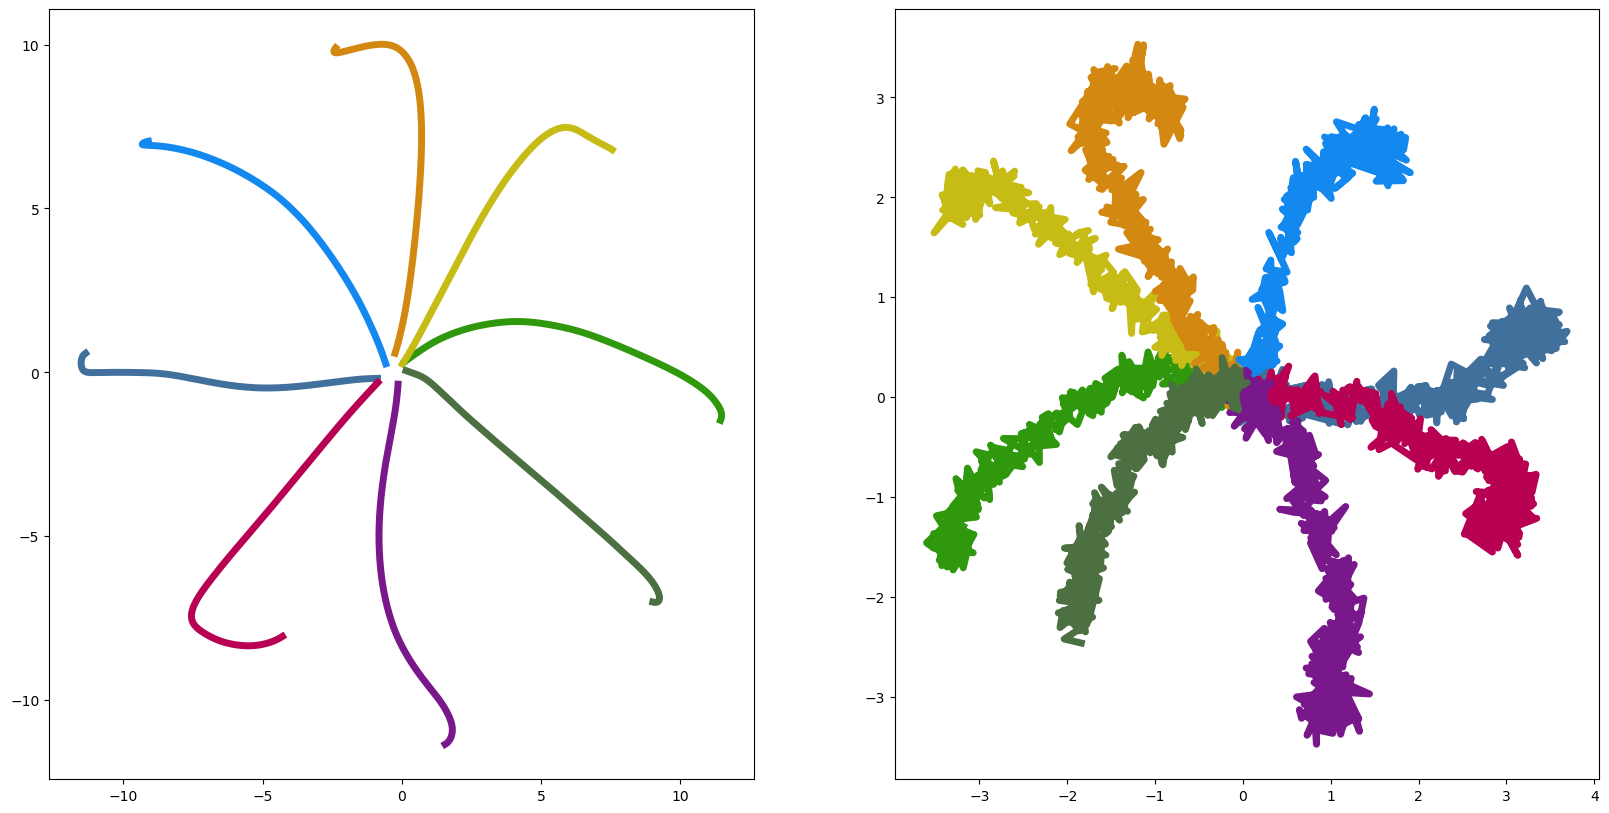

In [12]:
fig, axs = plt.subplots(1, 2, figsize=(20, 10))

num_examples_per_angle = np.array([len(test_indices_angle) for test_indices_angle in test_indices])

# load results from pretrained model 
test_encoder_outputs = np.load(os.path.join(os.getcwd(), 'example/monkey_reaching_supervised_example/enc_outputs.npy'))

colors = ['#2F980C', '#C7BC16', '#D38811', '#1389F0','#40709B', '#B80152', '#78188B','#4C7041']

for i, angle in enumerate(unique_angles):
    mean_hand_pos = np.mean(test_target_data[i], axis=0)[..., 100:] # the first 100 ms are before movement onset
    axs[0].plot(mean_hand_pos[0], mean_hand_pos[1], color=colors[i], linewidth=5)
    mean_encoder_outputs = np.mean(encoder_outputs[np.sum(num_examples_per_angle[:i]):np.sum(num_examples_per_angle[:i+1])].cpu().numpy(), axis=0)
    axs[1].plot(mean_encoder_outputs[0, 100 + tau_p:], mean_encoder_outputs[1, 100 + tau_p:], color=colors[i], linewidth=5)

In [10]:
!jupyter nbconvert --to html demo.ipynb

[NbConvertApp] Converting notebook demo.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 1 image(s).
[NbConvertApp] Writing 504035 bytes to demo.html
